# ANALYSIS OF RESULTS

In [1]:
import joblib
from sklearn.metrics import matthews_corrcoef , confusion_matrix, classification_report,roc_curve, auc
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os
module_path = os.path.abspath(os.path.join('..', 'codes'))
if module_path not in sys.path:
    sys.path.append(module_path)
from confusion_matrix import plot_cm
from visualization_utils import visualize_feature_importance, plot_multiclass_roc_curve, plot_feature_distribution_by_stage

In [51]:
df=pd.read_csv("../data/data_refined_stratifkfold.csv")
x_bench,y_bench=df.query("Set=='Benchmark'").drop(columns=['Set','Stage']),df.query("Set=='Benchmark'")['Stage']
bench_pred_tree = joblib.load('../data/benchmark_prediction_tree.pkl')
bench_pred_svm = joblib.load('../data/benchmark_prediction_svm.pkl')
bench_pred_lr = joblib.load('../data/benchmark_prediction_lr.pkl')
with open('../models/tree_model.pkl', 'rb') as f:
    loaded_tree = pickle.load(f)
with open('../models/lr_model.pkl', 'rb') as f:
    loaded_lr = pickle.load(f)
with open('../models/svm_model.pkl', 'rb') as f:
    loaded_svm = pickle.load(f) # Ci serve per la ROC
features_tree = joblib.load('../data/best_features_list_tree.pkl')
features_lr = joblib.load('../data/best_features_list_lr.pkl')
features_svm = joblib.load('../data/best_features_list_svm.pkl') # Se serve
x_bench_tree = x_bench[features_tree]
x_bench_lr = x_bench[features_lr]
x_bench_svm = x_bench[features_svm]
x_trainval,y_trainval=df.query("Set=='1' or Set=='2' or Set=='3' or Set=='4' or Set=='5'").drop(columns=['Set','Stage']),df.query("Set=='1' or Set=='2' or Set=='3' or Set=='4' or Set=='5'")['Stage']

In [3]:

# complete report performances benchmark tree
print("\n--- Classification Report tree  ---")
print(classification_report(y_bench, bench_pred_tree))
print("MCC  ", matthews_corrcoef(y_bench,bench_pred_tree))



# Complete report performances benchmark svm
print("\n--- Classification Report svm  ---")
print(classification_report(y_bench, bench_pred_svm))
print("MCC  ",matthews_corrcoef(y_bench,bench_pred_svm))






# complete report performances benchmark  logistic regression
print("\n--- Classification Report lr ---")
print(classification_report(y_bench, bench_pred_lr))
print("MCC  ",matthews_corrcoef(y_bench,bench_pred_lr))



--- Classification Report tree  ---
              precision    recall  f1-score   support

         1.0       0.12      0.33      0.18         3
         2.0       0.13      0.14      0.14        14
         3.0       0.50      0.42      0.45        24
         4.0       0.70      0.64      0.67        22

    accuracy                           0.43        63
   macro avg       0.36      0.38      0.36        63
weighted avg       0.47      0.43      0.45        63

MCC   0.19601429225839503

--- Classification Report svm  ---
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         3
         2.0       0.39      0.50      0.44        14
         3.0       0.50      0.29      0.37        24
         4.0       0.70      0.73      0.71        22

    accuracy                           0.48        63
   macro avg       0.40      0.38      0.38        63
weighted avg       0.52      0.48      0.49        63

MCC   0.27780167190974636

--- 

### Comparative Analysis of Classification Metrics

The quantitative evaluation of the three models on the Benchmark Set reveals distinct behavioral patterns, with **Logistic Regression (LR)** emerging as the most balanced classifier overall, while the **Support Vector Machine (SVM)** excels in specific sensitivity tasks.

#### 1. Logistic Regression (The Overall Winner)
* **Global Performance (MCC: 0.312):** The Logistic Regression achieves the highest Matthews Correlation Coefficient, indicating the best overall agreement between predictions and actual labels across all classes. It is the most robust model for this dataset.
* **Stage 1 Anomaly:** It is the only model capable of identifying the minority class (Stage 1) with a **Recall of 0.67** (correctly identifying 2 out of 3 patients). However, the low Precision (0.17) suggests it achieves this by "casting a wide net," generating several false positives for this stage.
* **Stage 4 (Severe):** It maintains a solid performance for the critical class (Precision 0.71, Recall 0.68), making it reliable for detecting several cases of cirrhosis.

#### 2. Support Vector Machine (The "Severe Case" Specialist)
* **Global Performance (MCC: 0.278):** The SVM ranks second. Its performance is heavily penalized by its complete inability to recognize Stage 1 (Recall 0.00, F1 0.00), likely due to the model focusing on the dominant classes during the optimization of the hyperplane.
* **Stage 4 Superiority:** Despite the lower overall score, the SVM achieves the **highest Recall for Stage 4 (0.73)** among all models. Clinically, this is significant: it is the most sensitive model for "ruling in" the most severe patients, missing the fewest cases of advanced cirrhosis compared to LR and Tree.

#### 3. Balanced Random Forest / Tree (The Underperformer)
* **Global Performance (MCC: 0.196):** The Tree-based model shows the weakest correlation. The drop in performance is largely driven by its failure in the "grey zone" of **Stage 2**.
* **The Stage 2 Collapse:** With a Precision of 0.13 and Recall of 0.14 for Stage 2, the model struggles significantly to distinguish early-intermediate disease from other stages, effectively performing little better than random chance for this specific subgroup (like we expected during EDA).
* **Reliable on Extremes:** Like the others, it performs adequately on Stage 4 (Recall 0.64), confirming that the biological signal for severe disease is strong enough to be picked up even by a sub-optimal model.

### Summary
While **Logistic Regression** offers the best trade-off across all stages (Highest MCC), the **SVM** might be preferred in a clinical screening context where minimizing False Negatives for severe Cirrhosis (Stage 4) is the primary objective. The **Tree** model, despite the rigorous stability selection, struggled to generalize on the intermediate stages of this specific test set.

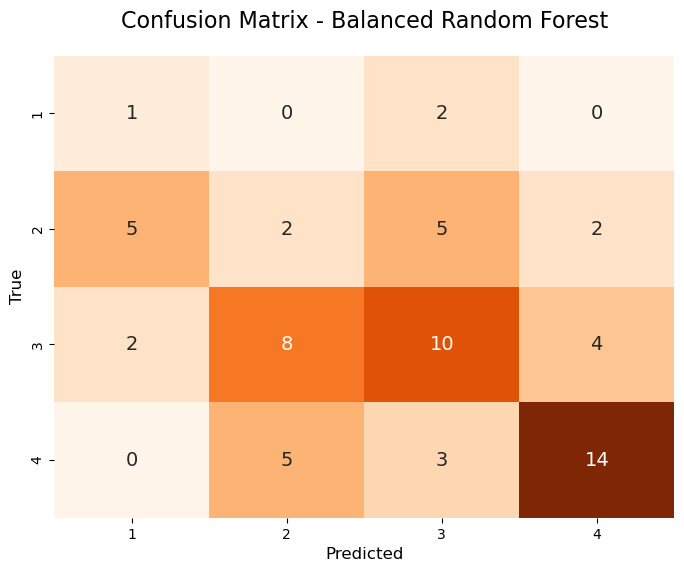

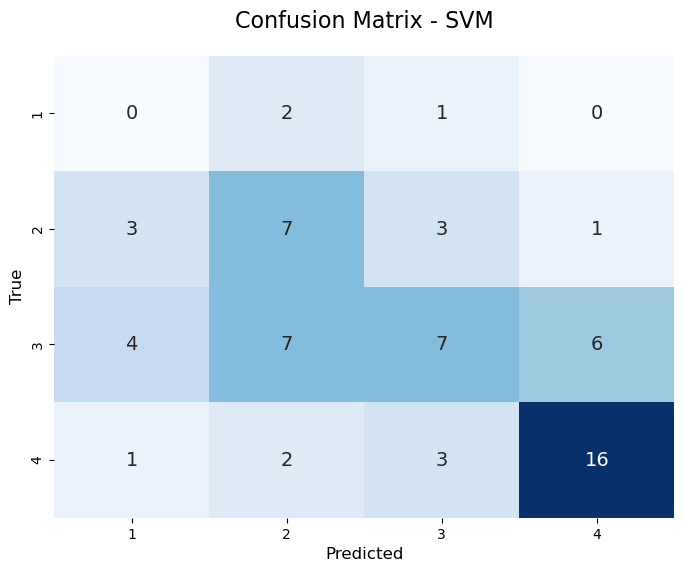

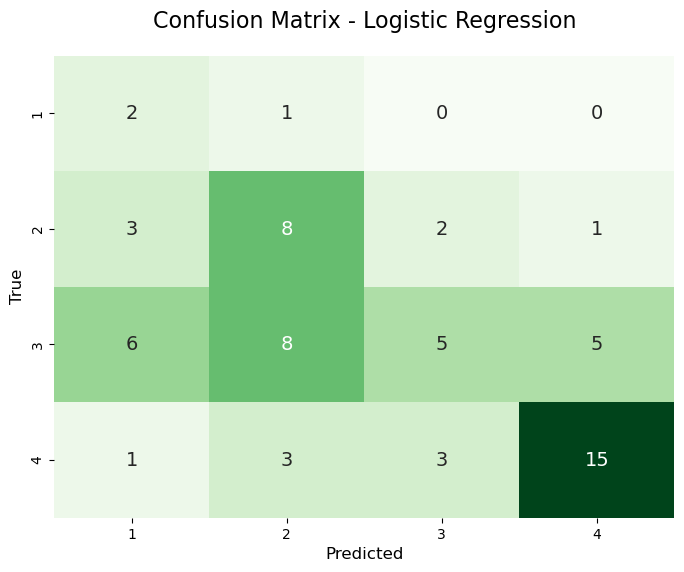

In [4]:
plot_cm(y_bench,bench_pred_tree,'Balanced Random Forest', 'Oranges','../figures/04_cm_tree.svg')
plot_cm(y_bench,bench_pred_svm,'SVM','Blues','../figures/04_cm_svm.svg')
plot_cm(y_bench,bench_pred_lr,'Logistic Regression', 'Greens', '../figures/04_cm_lr.svg')

### Comparative Analysis of Confusion Matrices

The confusion matrices provide a granular view of the models' misclassification patterns, revealing strengths and weaknesses that aggregate metrics might obscure.

* **Balanced Random Forest (Tree):**
    The Tree-based model demonstrates a robust ability to identify severe cases, correctly classifying a significant portion of **Stage 4** patients (14/22). Crucially, it exhibits excellent separation between the extremes: no Stage 4 patient was misclassified as Stage 1, minimizing the risk of discharging a severe patient as healthy. However, the model struggles with the "grey zone," frequently confusing **Stage 3** with Stage 2 (8 cases). Performance on **Stage 1** is limited, likely due to the extreme scarcity of training samples for this class.

* **Support Vector Machine (SVM):**
    The SVM achieves the highest sensitivity for the critical class, correctly identifying the highest number of **Stage 4** patients (16/22). It also outperforms the Random Forest in recognizing **Stage 2** (7 correct predictions vs. 2). However, this sensitivity comes with a trade-off: unlike the Tree model, the SVM commits a critical error, misclassifying one Stage 4 patient as Stage 1 (a severe "false negative"). Similar to the other models, it fails to identify Stage 1 cases entirely (0 correct predictions), assigning them to adjacent stages.

* **Logistic Regression (LR):**
    Surprisingly, the Linear model proved to be the most capable at detecting the minority class (**Stage 1**), correctly identifying 2 out of the 3 available cases, a higher recall (sensitivity) than its non-linear counterparts. It also showed solid performance on **Stage 2** (8/14 correct) and **Stage 4** (15/22 correct). However, its limitations become evident in **Stage 3**, where it exhibits the highest confusion rate, frequently underestimating the severity by misclassifying these patients as Stage 1 or 2.

## Analysis TREE MODEL BASED 

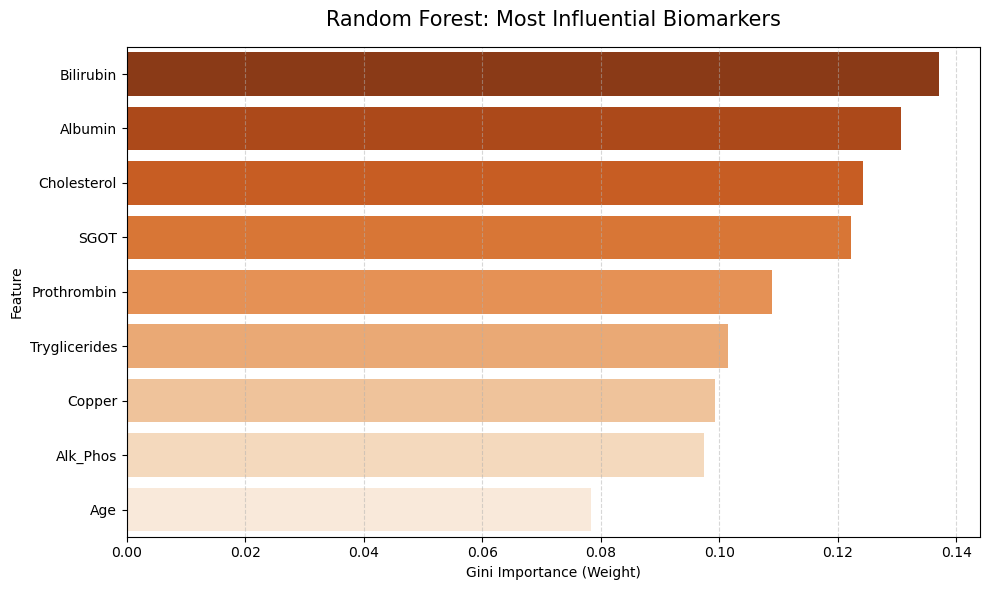

In [7]:
visualize_feature_importance(loaded_tree, features_tree, model_type="tree", title="Random Forest: Most Influential Biomarkers")



We can see that are all numerical variables. So we can visualize better in order of importances how is the biomarker progression across disease stage on benchmark set

In [46]:
tmp_features_to_plot.query('Feature=="Bilirubin"')['Imp'].item()

0.13715256293546524

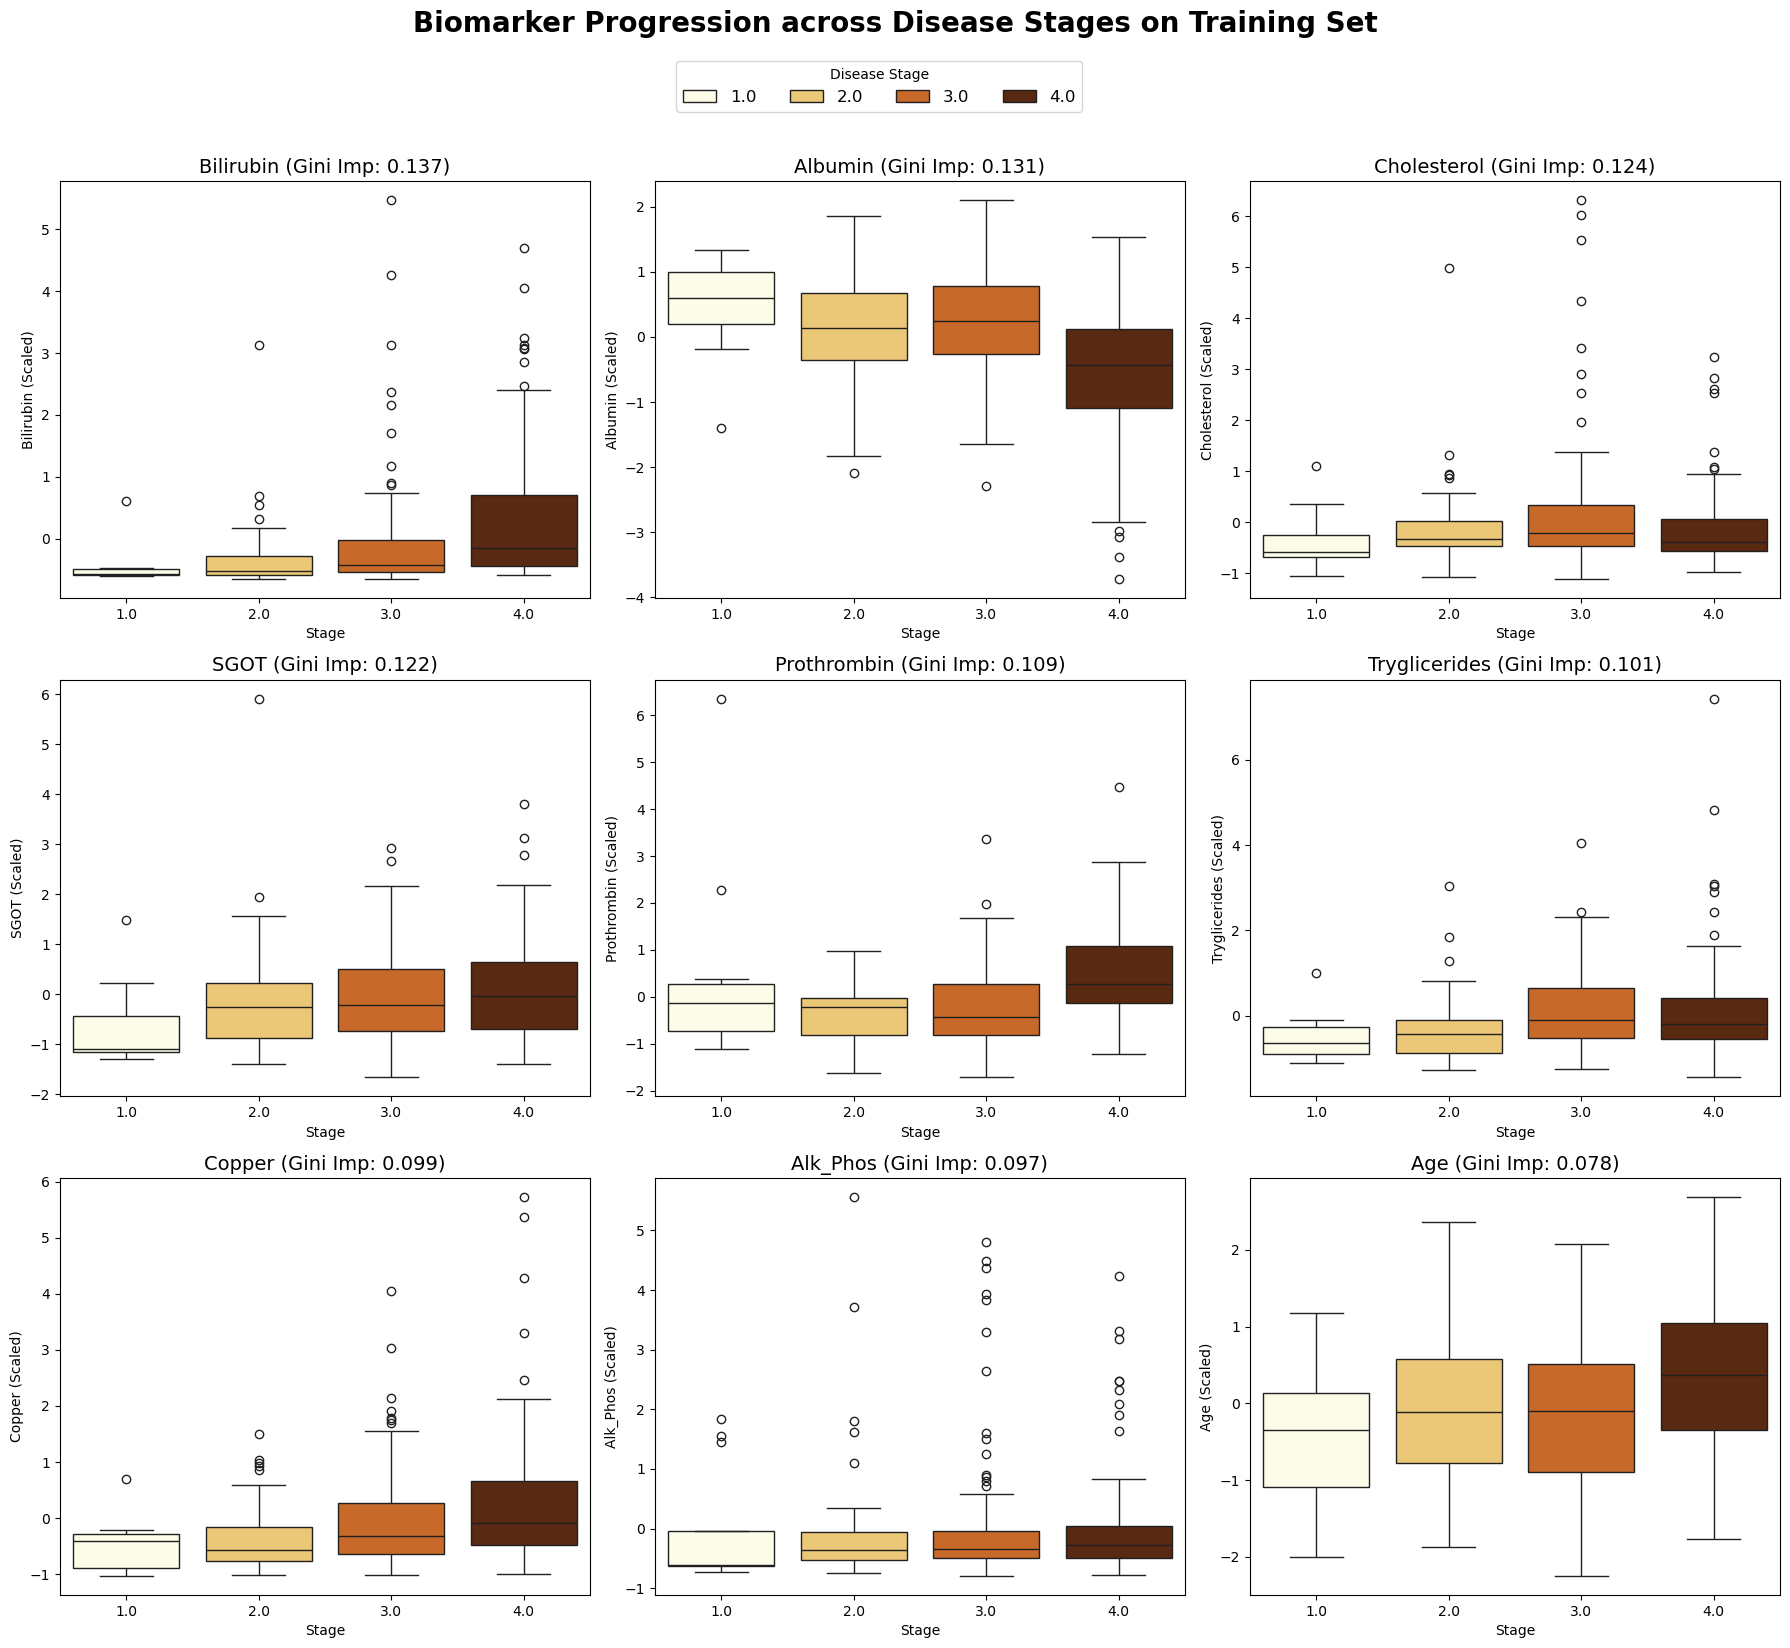

In [54]:
importances = loaded_tree.named_steps['rf'].feature_importances_
names = loaded_tree.feature_names_in_
tmp_features_to_plot=pd.DataFrame({'Feature': names, 'Imp': importances}).sort_values(by='Imp', ascending=False)
features_to_plot = tmp_features_to_plot['Feature'].tolist()
features_to_plot
n_cols = 3
n_rows = len(features_to_plot)
training_set=x_trainval.copy()
training_set['Stage']=y_trainval
# initialize the main figure with dynamic height calculation
plt.figure(figsize=(18, 5 * n_rows))
plt.suptitle("Biomarker Progression across Disease Stages on Training Set", fontsize=20, weight='bold', y=1.02)# add a main title to the visualization
for i, feature in enumerate(features_to_plot):
    fig=plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x='Stage', y=feature, data=training_set, hue='Stage', palette='YlOrBr')# generate boxplot to visualize distribution and outliers across stages
    plt.title(f'{feature} (Gini Imp: {tmp_features_to_plot.query(f'Feature=="{feature}"')['Imp'].item():.3f})', fontsize=14)# set dynamic title including the correlation coefficient for immediate context.
    plt.xlabel('Stage')
    plt.ylabel(f'{feature} (Scaled)')
    fig.get_legend().remove() # remove individual legends to make possible print only one legend for all the graphs.
handles, labels = fig.get_legend_handles_labels() # extract legend handles and labels to use them globally 
plt.tight_layout()
fig.legend(handles, labels, ncol=4, title='Disease Stage', fontsize=12, bbox_to_anchor=(-0.3,3.7))
plt.savefig('../figures/04_dis_tree_model.svg', bbox_inches='tight')
plt.show()

Although Random Forest ensemble models can be inherently opaque regarding their internal feature ranking criteria, a closer analysis reveals that the biomarkers with the highest Gini importance were not necessarily those exhibiting a linear progression, but rather those demonstrating steep and step-like distinctions between stages. These thresholds do not always separate all stages simultaneously; often, they serve to isolate a single specific stage from the rest. This logic is most evident in the case of Bilirubin. These markers ranked highest because they exhibited the sharpest differentiation specifically acting as a distinct "alarm signal" for the terminal phase despite lacking a linear trend across the earlier stages.  Or also Cholesterol, that could be useful to distinguish Stage 3 compared on the other Stages, and Albumin that indeed shows a very step-like difference between Stage 1 and 4. Conversely, biomarkers such as Alk_Phos, which displayed a flatter distribution with minimal variance between groups, provided little information gain and were consequently ranked among the lowest. Similarly, Age proved less effective for discriminating intermediate disease, likely because the distribution overlap between Stage 2 and Stage 3 prevented the algorithm from establishing a clear splitting criterion for these specific classes.

## Analysis SVM MODEL BASED 

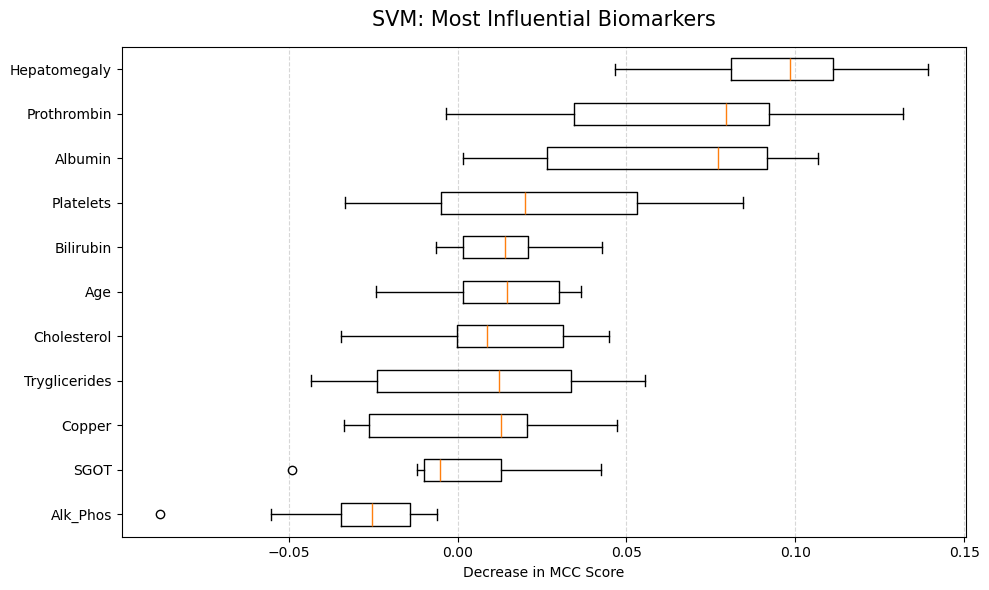

In [55]:
visualize_feature_importance(loaded_svm, features_svm,"svm", x_bench_svm, y_bench, "SVM: Most Influential Biomarkers")


## Analysis LR MODEL BASED 

In [ ]:
visualize_feature_importance(loaded_lr, features_lr, model_type="lr", title="Logistic Regression: Most Influential Biomarkers")

## ROC CURVE ALL THREE MODELS

In [ ]:
models_dict = {
    "Logistic Regression": loaded_lr,
    "Random Forest": loaded_tree,
    "SVM": loaded_svm
}

data_dict = {
    "Logistic Regression": x_bench_lr,  
    "Random Forest": x_bench_tree,      
    "SVM": x_bench_svm                
}
plot_multiclass_roc_curve(models_dict, data_dict, y_bench, target_class=4)
